In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load only the first 10,000 rows of the dataset
df_og = pd.read_csv('/content/WELFake_Dataset.csv', nrows=10000)

In [3]:
df_og.to_excel('/content/fake_news_subset.xlsx', index=False)

df = df_og.copy()
print(df)


      Unnamed: 0                                              title  \
0              0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1              1                                                NaN   
2              2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3              3  Bobby Jindal, raised Hindu, uses story of Chri...   
4              4  SATAN 2: Russia unvelis an image of its terrif...   
...          ...                                                ...   
9995        9995  Yemen's Saleh ready to turn new page if Saudi-...   
9996        9996  Anonymous Hacker Fighting For Justina Pelletie...   
9997        9997  Hot-Air Balloon Crash in Texas Kills 16, Offic...   
9998        9998  Palme d’Or Goes to a Ken Loach Film at Cannes ...   
9999        9999  Mike Pence won the debate by throwing Donald T...   

                                                   text  label  
0     No comment is expected from Barack Obama Membe...      1  
1        Did they

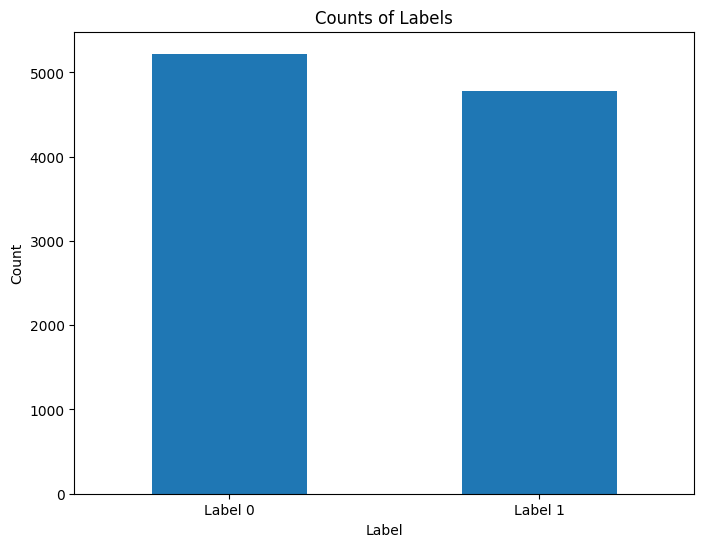

In [4]:
import matplotlib.pyplot as plt


# Calculate the counts of each label
label_counts = df['label'].value_counts()

# Plotting the counts as a histogram
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Counts of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Label 0', 'Label 1'], rotation=0)  # Set the x-ticks to show label names
plt.show()


In [5]:

#Filtering by frequency

from collections import Counter
import re

# Define a function to clean and split text into words
def clean_and_split(text):
    # Remove non-alphabetic characters and split into words
    words = re.sub("[^a-zA-Z]", " ", str(text)).split()
    return words

# Apply the function to each row in the 'text' column and count the words
all_words = df['text'].apply(clean_and_split).sum()
word_counts = Counter(all_words)

# Get the 20 most common and 20 least common words
most_common_20 = word_counts.most_common(20)
least_common_20 = word_counts.most_common()[:-21:-1]

# Now we'll remove these words from the 'text' column
most_least_common = set([word for word, count in most_common_20 + least_common_20])

def filter_words(text):
    words = clean_and_split(text)
    return ' '.join([word for word in words if word not in most_least_common])

df['filtered_text'] = df['text'].apply(filter_words)


In [6]:

#Removing stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


# NLTK's list of English stop words
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words from text
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Remove stop words from the 'filtered_text' column
df['filtered_text_no_stopwords'] = df['filtered_text'].apply(remove_stop_words)

df['filtered_text_no_stopwords'].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    comment expected Barack Obama Members FYF FukY...
1                           post votes Hillary already
2    demonstrators gathered last night exercising c...
3    dozen politically active pastors came private ...
4    RS Sarmat missile dubbed Satan replace SS Flie...
Name: filtered_text_no_stopwords, dtype: object

In [7]:
# Apply lower casing to the 'filtered_text_no_stopwords' column
df['filtered_text_no_stopwords'] = df['filtered_text_no_stopwords'].str.lower()

df['filtered_text_no_stopwords'].head()


0    comment expected barack obama members fyf fuky...
1                           post votes hillary already
2    demonstrators gathered last night exercising c...
3    dozen politically active pastors came private ...
4    rs sarmat missile dubbed satan replace ss flie...
Name: filtered_text_no_stopwords, dtype: object

In [8]:
# Applying stemming
from nltk.stem import PorterStemmer

# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Define a function to apply stemming to a text
def stem_text(text):
    word_tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_tokens)

# Apply stemming to the 'filtered_text_no_stopwords' column
df['stemmed_text'] = df['filtered_text_no_stopwords'].apply(stem_text)

df['stemmed_text'].head()


0    comment expect barack obama member fyf fukyofl...
1                            post vote hillari alreadi
2    demonstr gather last night exercis constitut p...
3    dozen polit activ pastor came privat dinner fr...
4    rs sarmat missil dub satan replac ss fli mile ...
Name: stemmed_text, dtype: object

In [9]:
# Drop rows where 'stemmed_text' is empty or 'label' is NaN
df_cleaned = df.dropna(subset=['label'])
df_cleaned = df_cleaned[df_cleaned['stemmed_text'].str.strip() != '']

df_cleaned.to_excel('/content/df_cleaned.xlsx', index=False)

In [10]:
#POS tagging

import spacy

# Load Spacy's English-language model
nlp = spacy.load("en_core_web_sm")

# Define the function to perform POS tagging and keep only nouns, verbs, and adjectives
def keep_nouns_verbs_adjectives(text):
    # Ensure text is a string
    if pd.isnull(text):
        return ""

    # Process the text through Spacy's pipeline
    doc = nlp(str(text))

    # Return a string of words that are nouns, verbs, or adjectives
    return ' '.join([token.text for token in doc if token.pos_ in ('NOUN', 'VERB', 'ADJ')])

# Apply the function to the 'text' column, making sure to handle NaN and convert to string
df['text_nva'] = df['text'].astype(str).apply(keep_nouns_verbs_adjectives)


In [11]:
# feature extraction

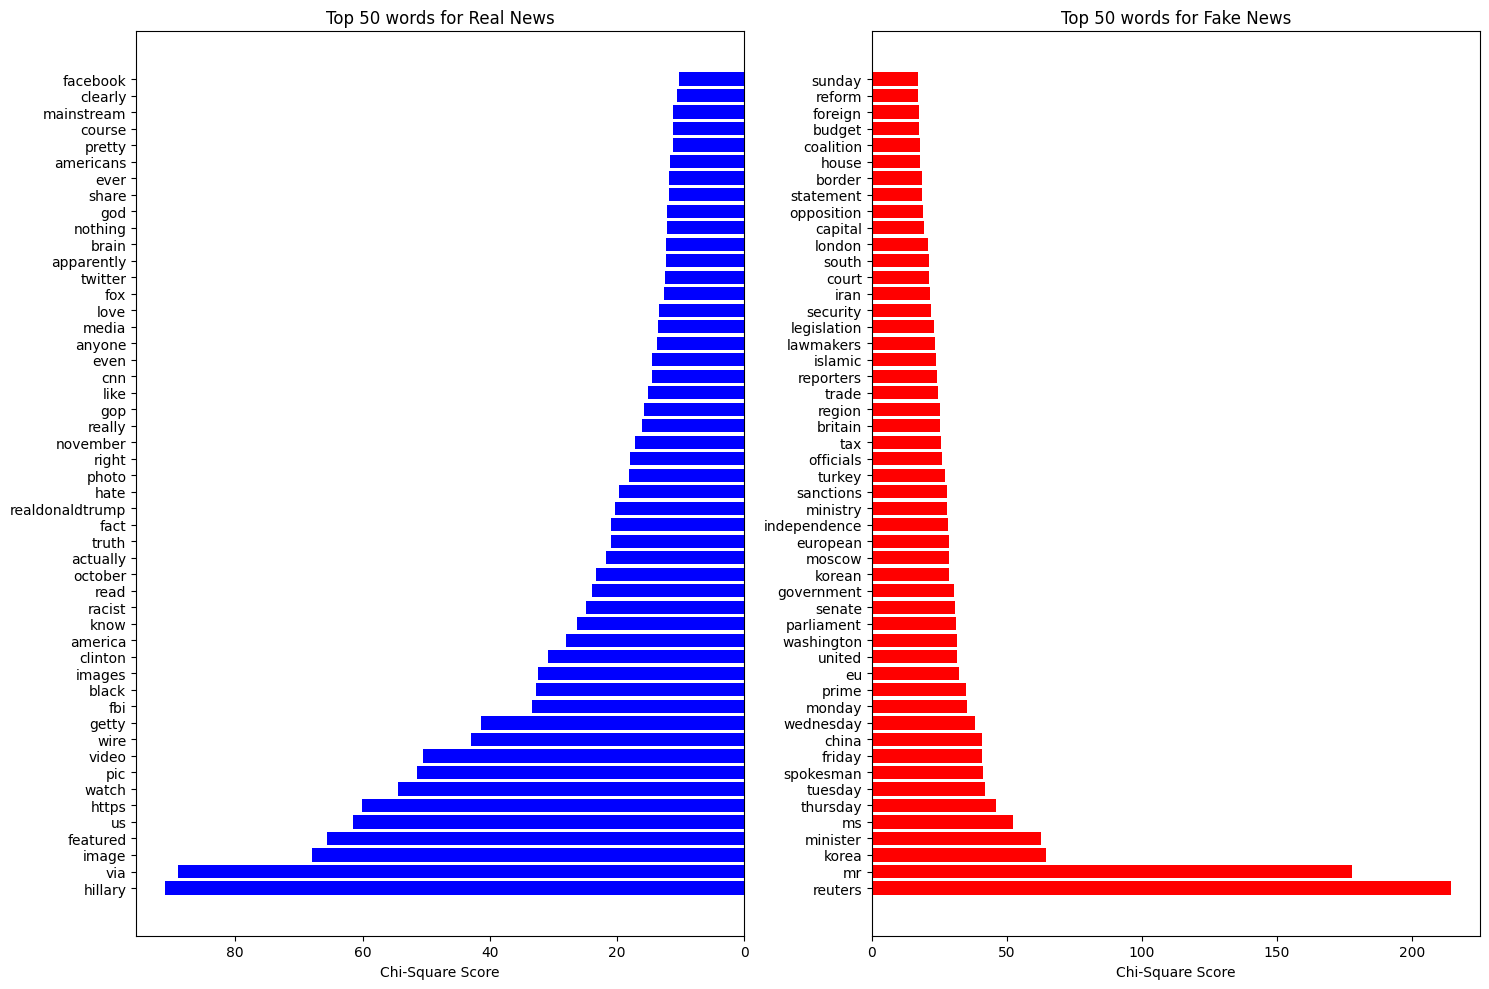

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np

# Define the stopwords
stopwords = {'including','told','guy','said','talks','goes','talk','let','co','get','last','expected','month','percent','ruling','north','seems','daily','com','entire','anti','declined','thing','knows','mean','agreed','week','got','see','adding','meeting','agreement','great','efforts','added','says','sought','remember','man'}

# Function to remove stopwords from a phrase
def remove_stopwords(phrase):
    return ' '.join(word for word in phrase.split() if word not in stopwords)

# Fill NaN values in the 'filtered_text_no_stopwords' column with an empty string
df['filtered_text_no_stopwords'].fillna('', inplace=True)
df['filtered_text_no_stopwords'] = df['filtered_text_no_stopwords'].apply(remove_stopwords)

# Vectorize the 'filtered_text_no_stopwords' column
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features to suit your needs
X = vectorizer.fit_transform(df['filtered_text_no_stopwords'])

# Get the sentiment labels
y = df['label']

# Apply Chi-Square test
chi2_scores, p_values = chi2(X, y)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Function to get the mean label for a given word
def mean_label(word):
    mask = df['filtered_text_no_stopwords'].str.contains(word, na=False)
    return df.loc[mask, 'label'].mean()

# Pair feature names with chi2 scores and filter by class
positive_features = [(name, score) for name, score in zip(feature_names, chi2_scores) if mean_label(name) > 0.5]
negative_features = [(name, score) for name, score in zip(feature_names, chi2_scores) if mean_label(name) < 0.5]

# Sort the features by chi2 score for each sentiment
top_positive_features = sorted(positive_features, key=lambda x: x[1], reverse=True)[:50]
top_negative_features = sorted(negative_features, key=lambda x: x[1], reverse=True)[:50]

# Extracting the features and their scores
positive_words, positive_scores = zip(*top_positive_features)
negative_words, negative_scores = zip(*top_negative_features)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Plotting the positive sentiment words
axes[0].barh(positive_words, positive_scores, color='blue')
axes[0].set_title('Top 50 words for Real News')
axes[0].invert_xaxis()  # labels read top-to-bottom
axes[0].set_xlabel('Chi-Square Score')

# Plotting the negative sentiment words
axes[1].barh(negative_words, negative_scores, color='red')
axes[1].set_title('Top 50 words for Fake News')
axes[1].set_xlabel('Chi-Square Score')

plt.tight_layout()
plt.show()


In [13]:
# Text modelling

In [14]:
df = df[df['label'] == 0].dropna()

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# NLTK's list of English stop words
stop_words = set(stopwords.words('english'))

# Manually add stopwords
manual_stop_words = {'year', 'get', 'way','used', 'many','percent','found','said','says','news','know', 'many', 'years', 'go','little','first', 'told','according','people','make','made','thousands','day','show','want','say','last','think','going','see','need','take'}

# Update the stop_words set
stop_words.update(manual_stop_words)

# Define a function to remove stop words from text
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower().strip() not in manual_stop_words]
    return ' '.join(filtered_text)

# Remove stop words from the 'filtered_text' column
df['filtered_text_no_stopwords'] = df['filtered_text_no_stopwords'].apply(remove_stop_words)

df['filtered_text_no_stopwords'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3     dozen politically active pastors came private ...
11    brussels reuters british prime minister theres...
12    washington reuters charles schumer top democra...
14    sports fans turn espn protest network social p...
15    rio de janeiro sao paulo reuters billionaire m...
Name: filtered_text_no_stopwords, dtype: object

<Figure size 1500x700 with 0 Axes>

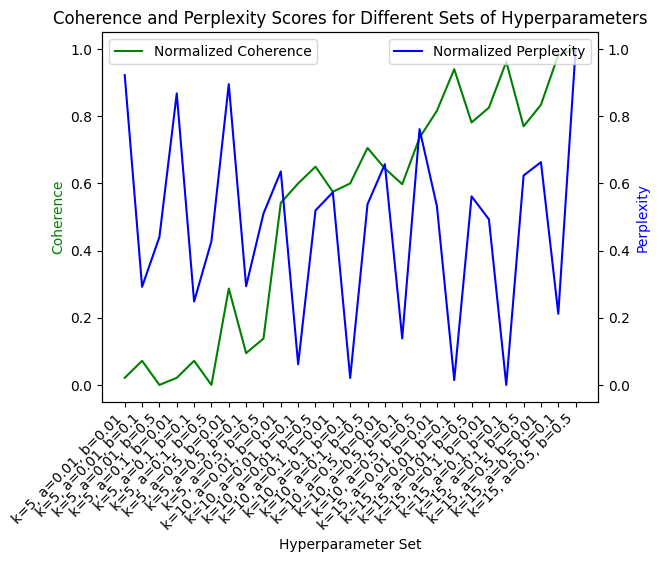

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import matutils


# Tokenize the text
tokenized_texts = [doc.split() for doc in df['filtered_text_no_stopwords']]

# Create a Gensim dictionary and corpus
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['filtered_text_no_stopwords'])

# Define the range of hyperparameters
k_values = [5, 10,15]
alpha_values = [0.01, 0.1, 0.5 ]
beta_values = [0.01, 0.1, 0.5]

# Initialize lists to store results
coherence_scores = []
perplexity_scores = []
params = []

# Apply LDA for Topic Modeling
for k in k_values:
    for alpha in alpha_values:
        for beta in beta_values:
            # Fit LDA model
            lda_model = LatentDirichletAllocation(n_components=k, doc_topic_prior=alpha, topic_word_prior=beta, random_state=42)
            lda_model.fit(dtm)

            # Compute Coherence Score
            topics = [[vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]] for topic in lda_model.components_]
            cm = CoherenceModel(topics=topics, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
            coherence_score = cm.get_coherence()

            # Compute Perplexity
            perplexity_score = lda_model.perplexity(dtm)

            # Store the results
            coherence_scores.append(coherence_score)
            perplexity_scores.append(perplexity_score)
            params.append((k, alpha, beta))

# Normalize scores for better visualization
coherence_scores = (coherence_scores - np.min(coherence_scores)) / (np.max(coherence_scores) - np.min(coherence_scores))
perplexity_scores = (perplexity_scores - np.min(perplexity_scores)) / (np.max(perplexity_scores) - np.min(perplexity_scores))

# Plotting the scores
plt.figure(figsize=(15, 7))

# Create plots with different y-axes
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(len(coherence_scores)), coherence_scores, 'g-', label='Normalized Coherence')
ax2.plot(range(len(perplexity_scores)), perplexity_scores, 'b-', label='Normalized Perplexity')

# Set labels and legends
ax1.set_xlabel('Hyperparameter Set')
ax1.set_ylabel('Coherence', color='g')
ax2.set_ylabel('Perplexity', color='b')

# Setting custom ticks for x-axis to show hyperparameters
param_ticks = [f'k={k}, a={a}, b={b}' for k, a, b in params]
ax1.set_xticks(range(len(params)))
ax1.set_xticklabels(param_ticks, rotation=45, ha='right')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Coherence and Perplexity Scores for Different Sets of Hyperparameters')
plt.show()


In [17]:
# Create a DataFrame to hold the hyperparameters and their corresponding scores
import pandas as pd

results_df = pd.DataFrame({
    'num_topics': [param[0] for param in params],
    'alpha': [param[1] for param in params],
    'beta': [param[2] for param in params],
    'coherence': coherence_scores,
    'perplexity': perplexity_scores
})

# Since we want high coherence and low perplexity, we can normalize (invert perplexity)
# and sum the two scores to find the best combination:
results_df['total_score'] = results_df['coherence'] - results_df['perplexity']

# Now sort the DataFrame to find the set of hyperparameters with the highest total_score
best_parameters = results_df.sort_values(by='total_score', ascending=False).head(1)

# Display the best hyperparameters
print("Best Hyperparameters:")
print(best_parameters)


Best Hyperparameters:
    num_topics  alpha  beta  coherence  perplexity  total_score
22          15    0.1   0.1   0.961727         0.0     0.961727


In [18]:

# going with best overal score considering coherence and perplexity: ( graph on powerpoint presentation not the one in this ipnyb, sorry I ran code for graph twice by mistake)



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter the DataFrame for rows where the label column is 0
filtered_df = df[df['label'] == 0]

# Step 1: Create a CountVectorizer representation of the documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(filtered_df['filtered_text_no_stopwords'])

# Step 2: Apply LDA to the document-term matrix
# Using the number of topics found to be ideal
best_k = 10
best_alpha = 0.1  # Replace with the best alpha found if available
best_beta = 0.1  # Replace with the best beta found if available
lda_count = LatentDirichletAllocation(n_components=best_k, random_state=42,
                                      doc_topic_prior=best_alpha, topic_word_prior=best_beta)
lda_count.fit(dtm)

# Step 3: Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
count_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda_count, count_feature_names, no_top_words)


Topic 0:
president trade britain eu world climate change united deal american
Topic 1:
clinton campaign republican party presidential election president voters democratic state
Topic 2:
state security united government iran military president states islamic russia
Topic 3:
mr ms president new house white twitter campaign media york
Topic 4:
like new time dr water children life women ms school
Topic 5:
party new health government house president election obamacare care vote
Topic 6:
police city time officers school students like state family killed
Topic 7:
tax house senate million billion new congress federal budget companies
Topic 8:
china korea reuters united nuclear south government states president military
Topic 9:
court president republican states law immigration reuters state senate united


In [19]:

# Considering highest coherence for k =15, alpha = 0.5 , beta = 0.5 ( we got more interpretable results , the graph for these results is the one on class powerpoint presentation)
#I ran it first time got these as best results:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter the DataFrame for rows where the label column is 0
filtered_df = df[df['label'] == 0]

# Step 1: Create a CountVectorizer representation of the documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(filtered_df['filtered_text_no_stopwords'])

# Step 2: Apply LDA to the document-term matrix
# Using the number of topics found to be ideal
best_k = 15
best_alpha = 0.5  # Replace with the best alpha found if available
best_beta = 0.5  # Replace with the best beta found if available
lda_count = LatentDirichletAllocation(n_components=best_k, random_state=42,
                                      doc_topic_prior=best_alpha, topic_word_prior=best_beta)
lda_count.fit(dtm)

# Step 3: Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
count_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda_count, count_feature_names, no_top_words)


Topic 0:
china president united russia minister states reuters trade eu european
Topic 1:
clinton campaign party election democratic voters state republican presidential hillary
Topic 2:
iran state military united security islamic states syria government turkey
Topic 3:
mr department president house investigation officials russian committee intelligence russia
Topic 4:
dr education school children water study kong students fish schools
Topic 5:
house new government tax president congress senate republican republicans health
Topic 6:
police city state law officers students school mr killed public
Topic 7:
tax puerto million rico taxes debt mnuchin income city billion
Topic 8:
saudi reuters arabia myanmar government rohingya lebanon country military french
Topic 9:
republican court immigration states president cruz state order new law
Topic 10:
mexico government opposition president taiwan reuters venezuela cuba mexican united
Topic 11:
sleep cambodia nepal kem sokha hun sen academies ka

In [21]:

# Considering highest coherence for k =10, alpha = 0.5 , beta = 0.5 (i mistakenly reran the graph and got theses results)
#I ran it second time got these as best results:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter the DataFrame for rows where the label column is 0
filtered_df = df[df['label'] == 0]

# Step 1: Create a CountVectorizer representation of the documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(filtered_df['filtered_text_no_stopwords'])

# Step 2: Apply LDA to the document-term matrix
# Using the number of topics found to be ideal
best_k = 10
best_alpha = 0.5  # Replace with the best alpha found if available
best_beta = 0.5  # Replace with the best beta found if available
lda_count = LatentDirichletAllocation(n_components=best_k, random_state=42,
                                      doc_topic_prior=best_alpha, topic_word_prior=best_beta)
lda_count.fit(dtm)

# Step 3: Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
count_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda_count, count_feature_names, no_top_words)


Topic 0:
president china russia united trade states eu european deal britain
Topic 1:
clinton campaign republican party presidential election president voters state democratic
Topic 2:
state iran military government security islamic united syria reuters states
Topic 3:
mr ms president new house white twitter media intelligence york
Topic 4:
like dr new time water children food study women life
Topic 5:
house president government new republicans republican party health tax senate
Topic 6:
police city time like school students new officers family mr
Topic 7:
tax million billion company new financial companies city money debt
Topic 8:
korea china reuters south nuclear united government korean states military
Topic 9:
court law states president state federal immigration reuters order united


In [ ]:
# Classification Models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

import gensim.downloader as api

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#from skopt.space import Real, Categorical, Integer
from scipy import sparse
!pip install scikit-optimize
from skopt import BayesSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
df_cleaned = pd.read_excel('/content/df_cleaned.xlsx')

In [ ]:
# Drop rows where 'stemmed_text' column is NaN and overwrite the original DataFrame
df_cleaned.dropna(subset=['stemmed_text'], inplace=True)
# Split by 60, 20, 20% for train, validation and test set
df_train, df_temp = train_test_split(df_cleaned, test_size=0.4, random_state=42)
df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)


In [ ]:
# Create BOW representation using the 'stemmed_text' column
np.random.seed(1)
vectorizer = CountVectorizer(max_features=2000,
                             decode_error='replace',
                             strip_accents='unicode',
                             stop_words='english')

# Fit the vectorizer on the training set
X_train_bow = vectorizer.fit_transform(df_train['stemmed_text'])

# Transform text on the test and validation sets
X_test_bow = vectorizer.transform(df_test['stemmed_text'])
X_validation_bow = vectorizer.transform(df_validation['stemmed_text'])

np.random.seed(1)
tfidf_vectorizer = TfidfVectorizer(max_features=2000,
                                   stop_words='english',
                                   strip_accents='unicode',
                                   decode_error='replace')

# Transform data to a TF-IDF rep
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['stemmed_text'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['stemmed_text'])
X_validation_tfidf = tfidf_vectorizer.transform(df_validation['stemmed_text'])

In [ ]:
# Load Google's pretrained Word2Vec model.
word2vec_model = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def text_to_vector_w2v(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)



# Apply the function to your dataframes
df_train['w2v_vec'] = df_train['stemmed_text'].apply(lambda x: text_to_vector_w2v(x, word2vec_model))
df_validation['w2v_vec'] = df_validation['stemmed_text'].apply(lambda x: text_to_vector_w2v(x, word2vec_model))
df_test['w2v_vec'] = df_test['stemmed_text'].apply(lambda x: text_to_vector_w2v(x, word2vec_model))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train = df_train['label']
y_validation = df_validation['label']

best_params = {
    'C': 159.47377635689693,
    'degree': 2,
    'gamma': 1.6064941443851992e-06,
    'kernel': 'rbf'
}
svm_classifier = SVC(**best_params)
# Train the SVM classifier
svm_classifier.fit(X_train_bow, y_train)

# Predict on the validation set
y_validation_pred = svm_classifier.predict(X_validation_bow)

# Calculate the accuracy on the validation set
validation_accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")

Precision: 0.8485663082437276
Recall: 0.9488977955911824
F1-score: 0.8959318826868495
Validation Accuracy: 0.8886075949367088


In [ ]:
# Bayes Search

In [ ]:
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer
import numpy as np
from sklearn.metrics import accuracy_score

# Set the random seed for reproducibility
np.random.seed(1)

# Assuming X_train_bow, X_validation_tfidf, y_train, and y_validation are already defined

# Define the search space for the SVM hyperparameters
search_space = {
    'C': Real(1e-6, 1e+6),
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
    'gamma': Real(1e-6, 1e+1),
    'degree': Integer(1, 5)
}

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    n_iter=20,  # Number of iterations
    cv=5,  # Cross-validation folding strategy
    n_jobs=-1,  # Use all available CPUs
    verbose=3
)

# Run the Bayesian optimization search
bayes_search.fit(X_train_tfidf, y_train)

# Best model found
print("Best model score:", bayes_search.best_score_)
print("Best model parameters:", bayes_search.best_params_)

# Use the best model to predict on the validation set
best_model = bayes_search.best_estimator_
y_validation_pred = best_model.predict(X_validation_tfidf)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
print(f"Validation Accuracy with best model: {validation_accuracy}")



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
# Initialize the SVM classifier with the best model parameters
best_params = bayes_search.best_params_

svm_classifier = SVC(**best_params)

# Fit the classifier on the training data
svm_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set using the best model
y_validation_pred = svm_classifier.predict(X_validation_tfidf)

# Calculate the accuracy on the validation set using the best model
validation_accuracy = accuracy_score(y_validation, y_validation_pred)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")


Precision: 0.9144278606965174
Recall: 0.9208416833667334
F1-score: 0.9176235646530204
Validation Accuracy: 0.9164556962025316


In [ ]:
# Set the random seed for reproducibility
np.random.seed(1)


# Define the search space for the SVM hyperparameters
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'degree': Integer(1, 5)
}

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    n_iter=20,  # Number of iterations
    cv=5,  # Cross-validation folding strategy
    n_jobs=-1,  # Use all available CPUs
    verbose=3
)

# Run the Bayesian optimization search
bayes_search.fit(X_train_tfidf, y_train)

# Best model found
print("Best model score:", bayes_search.best_score_)
print("Best model parameters:", bayes_search.best_params_)

# Use the best model to predict on the validation set
best_model = bayes_search.best_estimator_
y_validation_pred = best_model.predict(X_validation_tfidf)
validation_accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
# Prepare the feature matrices and target vectors
np.random.seed(1)

X_train_w2v = np.array(df_train['w2v_vec'].tolist())
X_validation_w2v = np.array(df_validation['w2v_vec'].tolist())

# Initialize and train the SVM classifier with the best model parameters
svm_classifier = SVC(
    C=370.1615573800143,
    degree=2,
    gamma=0.03408402306492268,
    kernel='sigmoid'
)
svm_classifier.fit(X_train_w2v, y_train)

# Predict on the validation set and evaluate accuracy
y_validation_pred = svm_classifier.predict(X_validation_w2v)
validation_accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")



Precision: 0.8534136546184738
Recall: 0.8517034068136272
F1-score: 0.8525576730190572
Validation Accuracy: 0.8511392405063292


In [ ]:
np.random.seed(1)

# Define the search space for the SVM hyperparameters
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),  # You can add more kernels like 'poly', 'sigmoid'
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
     'degree': Integer(1, 5)
}

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    n_iter=20,  # Number of iterations
    cv=5,  # Cross-validation folding strategy
    n_jobs=-1,  # Use all available CPUs
    verbose=3
)

# Prepare the data
X_train_w2v = np.array(df_train['w2v_vec'].tolist())
y_train = df_train['label']
X_validation_w2v = np.array(df_validation['w2v_vec'].tolist())
y_validation = df_validation['label']

# Run the Bayesian optimization search
bayes_search.fit(X_train_w2v, y_train)

# Best model found
print("Best model score:", bayes_search.best_score_)
print("Best model parameters:", bayes_search.best_params_)

# Use the best model to predict on the validation set
best_model = bayes_search.best_estimator_
y_validation_pred = best_model.predict(X_validation_w2v)
validation_accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# Tokenize the text to create sequences
np.random.seed(1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['stemmed_text'])
X_train_sequences = tokenizer.texts_to_sequences(df_train['stemmed_text'])
X_validation_sequences = tokenizer.texts_to_sequences(df_validation['stemmed_text'])

# Pad the sequences to have the same length
X_train_padded = pad_sequences(X_train_sequences, maxlen=200)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=200)

# Get the word index from the tokenizer
word_index = tokenizer.word_index

# Create the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word2vec_model.vector_size))
for word, i in word_index.items():
    if word in word2vec_model.key_to_index:
        embedding_vector = word2vec_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    word2vec_model.vector_size,
                    weights=[embedding_matrix],
                    input_length=200,
                    trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_padded, df_train['label'], epochs=10, validation_data=(X_validation_padded, df_validation['label']))

# Evaluate the model
validation_accuracy = model.evaluate(X_validation_padded, df_validation['label'])[1]
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming df_train['text'] and df_validation['text'] hold your text data
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)  # Adjust based on your vocabulary size
tokenizer.fit_on_texts(df_train['stemmed_text'])

# Convert texts to sequences of integers
X_train = tokenizer.texts_to_sequences(df_train['stemmed_text'])
X_validation = tokenizer.texts_to_sequences(df_validation['stemmed_text'])

# Pad the sequences
max_length = 200  # Adjust based on the length of your sequences
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_validation = pad_sequences(X_validation, maxlen=max_length, padding='post')

# Assuming df_train['label'] and df_validation['label'] are your target variables
y_train = df_train['label'].values
y_validation = df_validation['label'].values

# Now, X_train, X_validation, y_train, and y_validation are defined and can be used to train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Evaluate the model
validation_accuracy = model.evaluate(X_validation, y_validation)[1]
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Validation Accuracy: {validation_accuracy}")


In [ ]:
#text summarization

In [ ]:

import pandas as pd
df_og = pd.read_excel('/content/fake_news_subset.xlsx')

In [ ]:
import numpy as np
import networkx as nx
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def textrank_summarize(title, text, num_sentences=3):
    # Combine title and text
    full_text = title + ". " + text

    # Tokenize text into sentences
    sentences = sent_tokenize(full_text)

    # Extract features from sentences using CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)

    # Calculate similarity matrix
    sim_matrix = cosine_similarity(X)

    # Convert similarity matrix into graph
    graph = nx.from_numpy_array(sim_matrix)

    # Calculate pagerank scores
    scores = nx.pagerank(graph)

    # Sort sentences by score
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Select top sentences for summary
    summary = ' '.join([sentence for score, sentence in ranked_sentences[:num_sentences]])

    return summary

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def summarize_text_column(df, title_column='title', text_column='text', num_sentences=3):
    summaries = []
    for index, row in df.iterrows():
        title = row[title_column]
        text = row[text_column]

        # Check for missing values
        if isinstance(title, str) and isinstance(text, str):
            summary = textrank_summarize(title, text, num_sentences)
        else:
            summary = np.nan

        summaries.append(summary)
    df['summary'] = summaries
    return df

# Summarize text and create a new column
fake_news_df = summarize_text_column(df_og)

# Print the DataFrame with the new 'summary' column
print(fake_news_df)

      Unnamed: 0                                              title  \
0              0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1              1                                                NaN   
2              2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3              3  Bobby Jindal, raised Hindu, uses story of Chri...   
4              4  SATAN 2: Russia unvelis an image of its terrif...   
...          ...                                                ...   
9995        9995  Yemen's Saleh ready to turn new page if Saudi-...   
9996        9996  Anonymous Hacker Fighting For Justina Pelletie...   
9997        9997  Hot-Air Balloon Crash in Texas Kills 16, Offic...   
9998        9998  Palme d’Or Goes to a Ken Loach Film at Cannes ...   
9999        9999  Mike Pence won the debate by throwing Donald T...   

                                                   text  label  \
0     No comment is expected from Barack Obama Membe...      1   
1        Did th

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
def processing(df):
    df = df.fillna('No info', axis=1)
    df['text'] = 'TITLE: ' + df.title + '; TEXT: ' + df.text
    return df

fake_news_df = processing(fake_news_df)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(fake_news_df['text'], fake_news_df['label'], test_size=0.2, random_state=42)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

texts_train_list = list(train_texts)
texts_val_list = list(val_texts)

tokenized_texts_train = tokenizer(texts_train_list, padding=True, truncation=True, return_tensors="pt", max_length=64)
tokenized_texts_val = tokenizer(texts_val_list, padding=True, truncation=True, return_tensors="pt", max_length=64)

train_labels = torch.tensor(list(train_labels))
val_labels = torch.tensor(list(val_labels))

train_dataset = TensorDataset(tokenized_texts_train['input_ids'], tokenized_texts_train['attention_mask'], train_labels)
val_dataset = TensorDataset(tokenized_texts_val['input_ids'], tokenized_texts_val['attention_mask'], val_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
from transformers import AutoModelForSequenceClassification


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, output_hidden_states=True, output_attentions=True)
model.to(device)

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6, Train Loss: 0.1907, Train Accuracy: 0.9177
Epoch 1/6, Validation Loss: 0.0931, Validation Accuracy: 0.9645
Epoch 2/6, Train Loss: 0.0532, Train Accuracy: 0.9824
Epoch 2/6, Validation Loss: 0.1820, Validation Accuracy: 0.9340
Epoch 3/6, Train Loss: 0.0239, Train Accuracy: 0.9915
Epoch 3/6, Validation Loss: 0.1640, Validation Accuracy: 0.9500
Epoch 4/6, Train Loss: 0.0116, Train Accuracy: 0.9966
Epoch 4/6, Validation Loss: 0.1630, Validation Accuracy: 0.9660
Epoch 5/6, Train Loss: 0.0048, Train Accuracy: 0.9986
Epoch 5/6, Validation Loss: 0.2062, Validation Accuracy: 0.9675
Epoch 6/6, Train Loss: 0.0030, Train Accuracy: 0.9991
Epoch 6/6, Validation Loss: 0.2300, Validation Accuracy: 0.9670


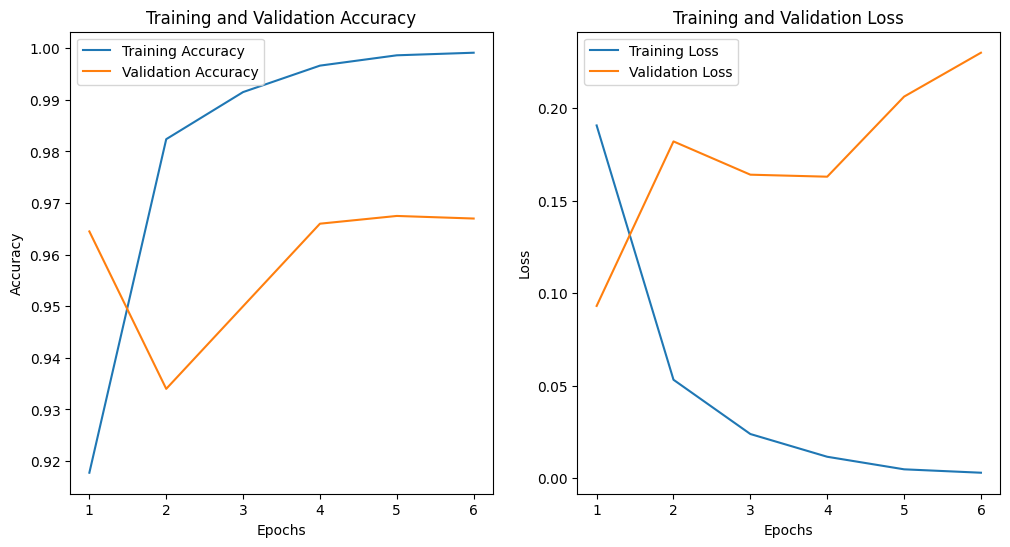

In [ ]:
import torch
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

# Let's call the model 'model'

optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-5}
], lr=5e-5)

loss_func = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

epochs = 6
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    for data in train_loader:
        inputs, masks, labels = data
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        running_train_loss += loss.item()
        loss.backward()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        train_correct += torch.sum(predictions == labels).item()

        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    model.eval()
    running_val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, masks, labels = data
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            running_val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_correct += torch.sum(predictions == labels).item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / len(val_dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Loop over validation data to extract tokens with highest attention weights and their average attention weights
tokens_with_highest_attention = []
average_attention_per_word = {}

total_tokens = 0

model.eval()  # Set the model to evaluation mode

# Function to extract tokens with highest attention weights and their average attention weights
def get_tokens_with_highest_attention(text, attention_weights):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Prepare attention weights for visualization
    attention_weights = attention_weights.squeeze(0).mean(dim=0)  # Average attention weights across all heads
    attention_weights = attention_weights.cpu().detach().numpy()

    # Calculate the average attention weight per word
    average_attention_per_word = {token: weight for token, weight in zip(tokens, attention_weights)}

    return average_attention_per_word

with torch.no_grad():
    for data in val_loader:
        inputs, masks, labels = data
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
        batch_size = inputs.size(0)
        total_tokens += batch_size * inputs.size(1)  # Calculate the total number of tokens

        outputs = model(inputs, attention_mask=masks)
        attentions = outputs.attentions[-1]  # Extract attention weights from the last layer

        for i in range(batch_size):
            input_text = tokenizer.decode(inputs[i].tolist())  # Convert tensor to list before decoding
            tokens_with_highest_attention.extend(get_tokens_with_highest_attention(input_text, attentions[i]))

            for token, weight in get_tokens_with_highest_attention(input_text, attentions[i]).items():
                if token in average_attention_per_word:
                    average_attention_per_word[token] += weight
                else:
                    average_attention_per_word[token] = weight

# Calculate the average attention weight per word
for token, weight in average_attention_per_word.items():
    average_attention_per_word[token] /= total_tokens

# Find tokens with the highest attention weights
tokens_with_highest_attention = sorted(average_attention_per_word.items(), key=lambda x: np.mean(x[1]), reverse=True)[:20]

# Print tokens with the highest attention weights
for token, avg_weight in tokens_with_highest_attention:
    print(f"Token: {token}, Average Attention Weight: {avg_weight}")


Token: title, Average Attention Weight: [0.00051141 0.00039868 0.00036418 0.00026223 0.0002229  0.00017621
 0.00014151 0.00011833 0.00011034 0.00010921 0.00010599 0.00011468
 0.00013142 0.00015072 0.0001711  0.00020082 0.00022525 0.00024851
 0.00026826 0.00027857 0.00027996 0.00027553 0.00026364 0.00025823
 0.00024903 0.0002393  0.00023171 0.00022386 0.0002274  0.00021968
 0.0002304  0.0002348  0.00024047 0.00025631 0.00025601 0.00027431
 0.00027752 0.00029343 0.00029168 0.00029392 0.00029048 0.00029702
 0.0002807  0.00027214 0.00026238 0.00027381 0.00025731 0.00024755
 0.00023424 0.0002383  0.00023854 0.00021894 0.00021316 0.00020361
 0.00019705 0.00018985 0.00017972 0.00018245 0.00017875 0.0001777
 0.00016126 0.00016491 0.00019827 0.00103932]
Token: :, Average Attention Weight: [5.59545762e-04 3.22853390e-04 3.46121873e-04 2.38862922e-04
 2.01547839e-04 1.58105016e-04 1.27808482e-04 1.06954285e-04
 1.00000201e-04 9.97401148e-05 9.74769646e-05 1.06861808e-04
 1.24605562e-04 1.47626604

In [ ]:
# Print tokens with the highest attention weights
for token, avg_weight in tokens_with_highest_attention:
    print(f"Token: {token}")


Token: title
Token: :
Token: [SEP]
Token: [CLS]
Token: text
Token: ;
Token: the
Token: -
Token: ,
Token: to
Token: s
Token: of
Token: (
Token: )
Token: a
Token: .
Token: on
Token: in
Token: ’
Token: trump


In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch

# Tokenize validation texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_val = tokenizer(list(val_texts), padding=True, truncation=True, return_tensors="pt", max_length=64)


input_ids_val = tokenized_texts_val['input_ids']
attention_mask_val = tokenized_texts_val['attention_mask']
labels_val = torch.tensor(list(val_labels))

val_dataset = TensorDataset(input_ids_val, attention_mask_val, labels_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model.to(device)


model.eval()
val_predictions_bert = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_predictions_bert.extend(preds.cpu().numpy())

# Convert predictions to numpy array
val_predictions_bert = np.array(val_predictions_bert)




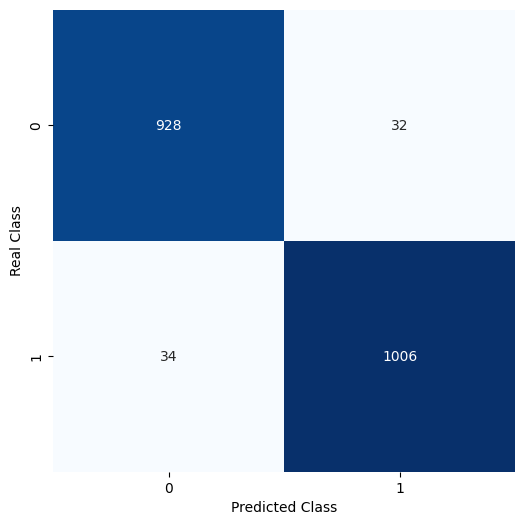

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm_bert = confusion_matrix(val_labels, val_predictions_bert)

# Visualize the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()


In [ ]:
true_negatives = cm_bert[0][0]
false_positives = cm_bert[0][1]
false_negatives = cm_bert[1][0]
true_positives = cm_bert[1][1]

precision_s = true_positives / (true_positives + false_positives)
recall_s = true_positives / (true_positives + false_negatives)
f1_s = 2 * (precision_s * recall_s) / (precision_s + recall_s)
accuracy_s = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1-score: {f1_s:.4f}')
print(f'Accuracy: {accuracy_s:.4f}')

Precision: 0.9692
Recall: 0.9673
F1-score: 0.9682
Accuracy: 0.9670


In [ ]:
#Bert trainer for summaries

In [ ]:
train_summ, val_summ, train_labels_summ, val_labels_summ = train_test_split(fake_news_df['summary'], fake_news_df['label'], test_size=0.2, random_state=42)

In [ ]:
summ_train_list = list(train_summ)
summ_val_list = list(val_summ)

tokenized_texts_train_summ = tokenizer(summ_train_list, padding=True, truncation=True, return_tensors="pt", max_length=64)
tokenized_texts_val_summ = tokenizer(summ_val_list, padding=True, truncation=True, return_tensors="pt", max_length=64)

train_labels_summ = torch.tensor(list(train_labels_summ))
val_labels_summ = torch.tensor(list(val_labels_summ))

train_dataset_summ = TensorDataset(tokenized_texts_train_summ['input_ids'], tokenized_texts_train_summ['attention_mask'], train_labels_summ)
val_dataset_summ = TensorDataset(tokenized_texts_val_summ['input_ids'], tokenized_texts_val_summ['attention_mask'], val_labels_summ)

train_loader_summ = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_summ = DataLoader(val_dataset, batch_size=64, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6, Training Loss: 0.1728, Training Accuracy: 0.9374
Epoch 1/6, Validation Loss: 0.1253, Validation Accuracy: 0.9490
Epoch 2/6, Training Loss: 0.0558, Training Accuracy: 0.9802
Epoch 2/6, Validation Loss: 0.0944, Validation Accuracy: 0.9680
Epoch 3/6, Training Loss: 0.0148, Training Accuracy: 0.9960
Epoch 3/6, Validation Loss: 0.1207, Validation Accuracy: 0.9660
Epoch 4/6, Training Loss: 0.0106, Training Accuracy: 0.9972
Epoch 4/6, Validation Loss: 0.1890, Validation Accuracy: 0.9670
Epoch 5/6, Training Loss: 0.0116, Training Accuracy: 0.9970
Epoch 5/6, Validation Loss: 0.1736, Validation Accuracy: 0.9670
Epoch 6/6, Training Loss: 0.0075, Training Accuracy: 0.9980
Epoch 6/6, Validation Loss: 0.1885, Validation Accuracy: 0.9655


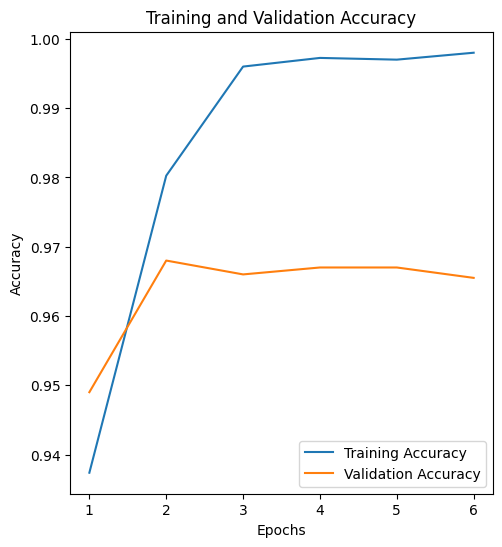

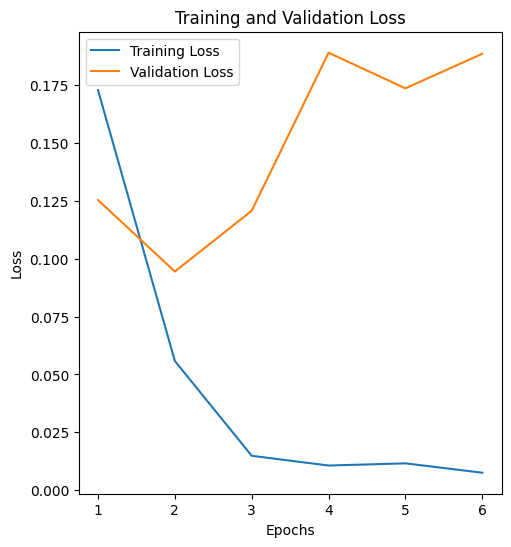

In [ ]:
import torch
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt


model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, output_hidden_states=True, output_attentions=True)
model.to(device)

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-5}
], lr=5e-5)

criterion = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

num_epochs = 6
train_losses_summ = []
val_losses_summ = []
train_accuracies_summ = []
val_accuracies_summ = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    tr_correct_preds = 0

    for batch in train_loader_summ:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        tr_loss = outputs.loss
        train_loss += tr_loss.item()
        tr_loss.backward()

        tr_logits = outputs.logits
        tr_preds = torch.argmax(tr_logits, dim=1)
        tr_correct_preds += torch.sum(tr_preds == labels).item()

        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    avg_train_loss = train_loss / len(train_loader_summ)
    train_accuracy = tr_correct_preds / len(train_dataset_summ)
    train_losses_summ.append(avg_train_loss)
    train_accuracies_summ.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")


    model.eval()
    val_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for batch in val_loader_summ:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels).item()


    avg_val_loss = val_loss / len(val_loader_summ)
    val_accuracy = correct_preds / len(val_dataset_summ)
    val_losses_summ.append(avg_val_loss)
    val_accuracies_summ.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



# Plot training and validation accuracy

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_summ, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies_summ, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses_summ, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_summ, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
# Tokenize validation texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_val = tokenizer(list(val_texts), padding=True, truncation=True, return_tensors="pt", max_length=64)

# Prepare data
input_ids_val = tokenized_texts_val['input_ids']
attention_mask_val = tokenized_texts_val['attention_mask']
labels_val = torch.tensor(list(val_labels))

val_dataset_summ = TensorDataset(input_ids_val, attention_mask_val, labels_val)
val_loader_summ = DataLoader(val_dataset_summ, batch_size=64, shuffle=False)

# Move model to appropriate device
model.to(device)

# Predict labels for validation dataset
model.eval()
val_predictions_bert = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_predictions_bert.extend(preds.cpu().numpy())

# Convert predictions to numpy array
val_predictions_bert_summ = np.array(val_predictions_bert)


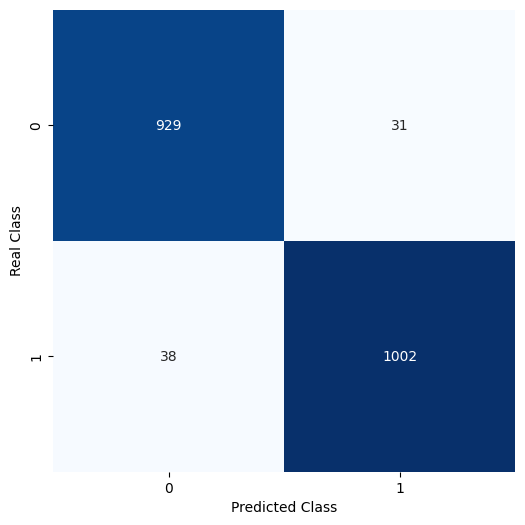

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm_bert = confusion_matrix(val_labels_summ, val_predictions_bert_summ)

# Visualize the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()


In [ ]:
true_negatives = cm_bert[0][0]
false_positives = cm_bert[0][1]
false_negatives = cm_bert[1][0]
true_positives = cm_bert[1][1]

precision_s = true_positives / (true_positives + false_positives)
recall_s = true_positives / (true_positives + false_negatives)
f1_s = 2 * (precision_s * recall_s) / (precision_s + recall_s)
accuracy_s = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1-score: {f1_s:.4f}')
print(f'Accuracy: {accuracy_s:.4f}')

Precision: 0.9700
Recall: 0.9635
F1-score: 0.9667
Accuracy: 0.9655
